<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/TEST_AAE_PED2_bg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install imageio
!pip install qpsolvers
#!pip install tensorflow_datasets
!pip install keras-layer-normalization
from google.colab import drive
#!pip install alive-progress
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [0]:


from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import skimage
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from os.path import join
from os import listdir
from os.path import isfile, join, isdir

#import keras
import argparse
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow
	
import statistics
import shutil

import matplotlib.pyplot as plt

import time
#from progress.bar import IncrementalBar

import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, Dropout, Activation, InputLayer
from keras.optimizers import Adam
from keras_layer_normalization import LayerNormalization
from keras.models import load_model
import csv

In [0]:
def get_single_test(single_test_path):
    
    sz = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
          sz = sz +1
    test = np.zeros(shape=(sz, conf.dim2, conf.dim3, conf.dim4))
    cnt = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
            #print("img path: "+join(single_test_path, f))
            img = Image.open(join(single_test_path, f)).resize((conf.dim2, conf.dim3))
            #cv2_imshow(np.array(img,dtype=np.float32))
            #cv2.waitKey(0)
            img = np.array(img, dtype=np.float32) / 256
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

def get_test_sequences(test_case_dir):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir))
    print("Test case loaded")
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3, conf.dim4))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3, conf.dim4))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    return sequences





In [0]:
class Config:
    def __init__(self, data_dir_, cwdir_name_, data_set):
        self.data_set_name = data_set
        self.data_dir = data_dir_
        self.data_set_dir = join(self.data_dir, data_set)
        self.cwdir_name = cwdir_name_
        self.cwdir = join(self.data_dir,self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")
        if not os.path.exists(self.cwdir):
            os.mkdir(self.cwdir)
            os.mkdir(self.run_data)
    
        if not os.path.exists(self.run_data):
            #shutil.rmtree(self.run_data)
            os.mkdir(self.run_data)
            os.makedirs(self.image_dir, exist_ok=True)

        self.DATASET_PATH = join(self.data_set_dir,"Train/")
        self.TEST_DIR = join(self.data_set_dir,"Test/")
        self.BATCH_SIZE = 2
        self.EPOCHS = 50
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = 0
        self.dim1 = 10
        self.dim2 = 256
        self.dim3 = 256
        self.dim4 = 1
        self.latent_dim = 327680


    def reconfig(self, new_name, batch_size = 4, epochs = 5, retrain = 0):
        self.cwdir_name = new_name
        self.cwdir = join(self.data_dir, self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")

        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = retrain
        if retrain == 0:
            print("Configuring train from scratch")
            if not os.path.exists(self.cwdir):
                os.mkdir(self.cwdir)
                os.mkdir(self.run_data)
    
            if os.path.exists(self.run_data):
                shutil.rmtree(self.run_data)
                os.mkdir(self.run_data)
                os.makedirs(self.image_dir, exist_ok=True)


conf = Config(data_dir_="/content/drive/My Drive/", cwdir_name_="Conv2DLSTM_AAE_PED2", data_set="UCSD_Anomaly_Dataset.v1p2/UCSDped2/") 


In [0]:
TestVideoFile_ped1 = list((36,2))
TestVideoFile_ped1 = [[60,152], [50,175], [91,200], [31,168], [5,90], [1,100], [1,175], [1,94], [1,48], [1,140],   [70,165],   [130,200],   [1,156],   [1,200],   [138,200],   [123,200],   [1,47],   [54,120],    [64,138],    [45,175],    [31,200],    [16,107],    [8,165],    [50,171],    [40,135],    [77,144],    [10,122],    [105,200],    [1,15],    [175,200],    [1,180],    [1,52],  [5,165],    [1,121],    [86,200],   [15,108]]

threshold = 0.5
def fill_gt_ped1(sr, id, color, threshold_abs):
    #plt.xlim((conf.dim1,len(sr)+conf.dim1))
    sr = np.reshape(sr, (sr.shape[0],))
    #print(sr.shape)
    #zeros = np.zeros((conf.dim1,))
    #print(zeros.shape)
    #plt.plot(np.concatenate((zeros, sr)))
    plt.plot(sr)
    plt.axvspan(TestVideoFile_ped1[id-1][0], TestVideoFile_ped1[id-1][1], alpha=0.5, color=color)
    plt.axhline(y=threshold_abs,linewidth=1, color='blue')
    if id == 6:
        plt.axvspan(140, 200, alpha=0.5, color=color)
    elif id == 7:
        plt.axvspan(110, 200, alpha=0.5, color=color) 
    elif id == 29:
        plt.axvspan(45, 113, alpha=0.5, color=color)
    elif id == 32:
        plt.axvspan(65, 115, alpha=0.5, color=color)


    plt.ylabel('regularity score sr_ae(t)')
    plt.xlabel('frame t')
    plt.show()


TestVideoFile_ped2 = list((12,2))
TestVideoFile_ped2 = [[61,180],[95,180],[1,146],[31,180],[1,129],[1,159],[46,180],[1,180],[1,120],[1,150],[1,180],[88,180]]

def fill_gt_ped2(sr, id, color, threshold_abs):
    #plt.xlim((conf.dim1,len(sr)+conf.dim1))
    sr = np.reshape(sr, (sr.shape[0],))
    #plt.plot(np.concatenate((np.zeros((conf.dim1,)), sr)))
    plt.plot(sr)
    plt.axvspan(TestVideoFile_ped2[id-1][0], TestVideoFile_ped2[id-1][1], alpha=0.5, color=color)
    plt.axhline(y=threshold_abs,linewidth=1, color='blue')
    plt.ylabel('regularity score sr_ae(t)')
    plt.xlabel('frame t')
    plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_9 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_10 (Laye (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_11 (Laye (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

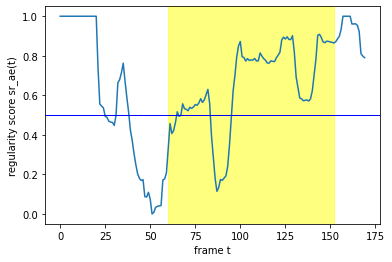

BGS show
Test case loaded
Test002 data set loaded


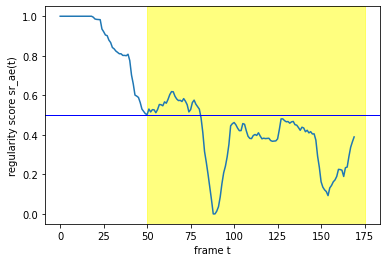

BGS show
Test case loaded
Test003 data set loaded


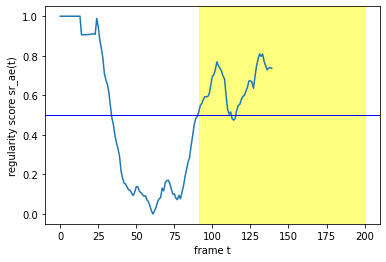

BGS show
Test case loaded
Test004 data set loaded


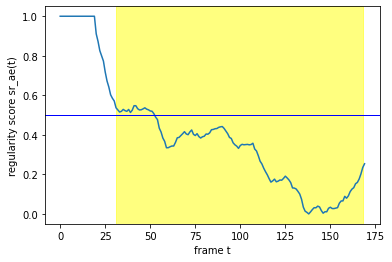

BGS show
Test case loaded
Test005 data set loaded


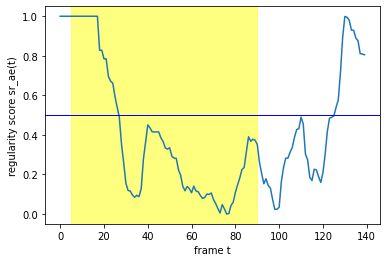

BGS show
Test case loaded
Test006 data set loaded


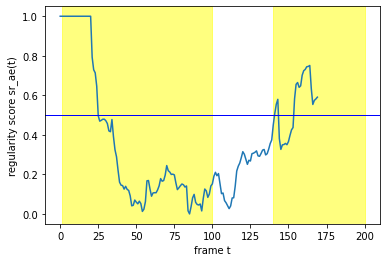

BGS show
Test case loaded
Test007 data set loaded


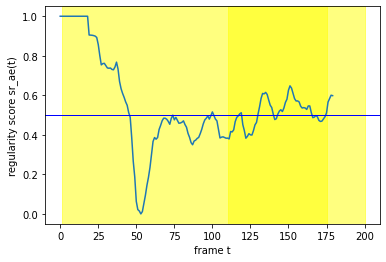

BGS show
Test case loaded
Test008 data set loaded


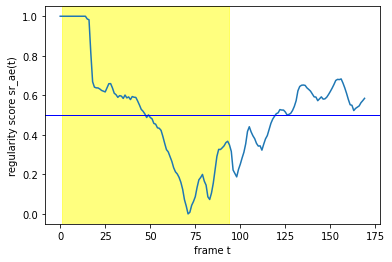

BGS show
Test case loaded
Test009 data set loaded


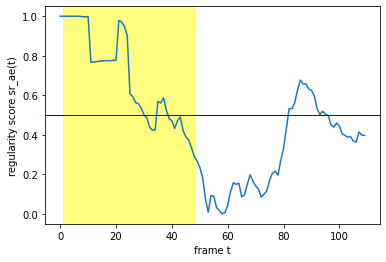

BGS show
Test case loaded
Test010 data set loaded


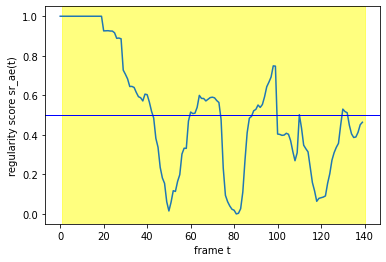

BGS show
Test case loaded
Test011 data set loaded


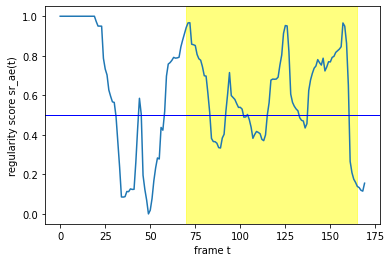

In [12]:
def build_model_aae():
  
    model_enc = load_model(conf.cwdir+"/model_gen_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    model_dec = load_model(conf.cwdir+"/model_dec_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    model_disc = load_model(conf.cwdir+"/model_dis_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})

    #model_enc = load_model("/content/drive/My Drive/model_gen_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    #model_dec = load_model("/content/drive/My Drive/model_dec_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    #model_disc = load_model("/content/drive/My Drive/model_dis_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})

    model_ae = Sequential()
    model_ae.add(model_enc)
    model_ae.add(model_dec)
    
    model_enc_disc = Sequential()
    model_enc_disc.add(model_enc)
    model_enc_disc.add(model_disc)
    
    return model_enc, model_dec, model_disc, model_ae, model_enc_disc

model_enc, model_dec, model_disc, model_ae, model_enc_disc = build_model_aae()

model_enc.summary()
model_dec.summary()
model_disc.summary()
model_ae.summary()
model_enc_disc.summary()

model_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
model_enc_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
model_ae.compile(optimizer=Adam(lr=1e-4, decay=1e-5, epsilon=1e-6), loss="mse")
#"/content/drive/My Drive/UCSD_Anomaly_Dataset.v1p2/model.hdf5"

#model_ae = load_model("/content/drive/My Drive/VAE/model1.hdf5",custom_objects={'LayerNormalization': LayerNormalization})

def evaluate_dis(sequences, model, id, dt):
    fooling_loss = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    sa = (fooling_loss - np.min(fooling_loss)) / (np.max(fooling_loss))
    sr = 1.0 - sa

    with open(join("/content/drive/My Drive/", 'sr_score.csv'), mode='a') as f:
        writer = csv.writer(f)
        writer.writerow([float(x[0]) for x in sr])
        f.close()

    threshold_abs = threshold#np.min(sr)+ (np.max(sr) - np.min(sr)) * threshold
    if dt == 1:
        fill_gt_ped1(sr, id, 'red', threshold_abs)
    elif dt == 2:
        fill_gt_ped2(sr, id, 'red', threshold_abs)
    #plt.plot(sr)
    #plt.ylabel('regularity score sr_dis(t)')
    #plt.xlabel('frame t')
    #plt.show()

def get_clips(test):
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :]
        sequences[i] = clip
    return sequences


def mask_array(bg_list):

    for p in range(0, bg_list.shape[0]):
        for r in range(256):
            for c in range(256):
                if bg_list[p][r][c] > 0:
                    bg_list[p][r][c] = 1
                else:
                    bg_list[p][r][c] = 0

    bg_list[0, :, :] = 0
    return bg_list

def evaluate_ae(sequences, model, id, dt, bg_list=[], do_mask=1):
  
    sz = len(sequences)

    reconstructed_sequences = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    #print(bg_list[10])

    masked_bg = mask_array(bg_list)
    bg_clips = get_clips(masked_bg)

    sequences = np.reshape(sequences, (sequences.shape[0], sequences.shape[1], sequences.shape[2], sequences.shape[3]))
    reconstructed_sequences = np.reshape(reconstructed_sequences, (reconstructed_sequences.shape[0], reconstructed_sequences.shape[1], reconstructed_sequences.shape[2], reconstructed_sequences.shape[3]))

    if do_mask == 1:
        sq_masked = np.multiply(sequences, bg_clips)
        rec_masked = np.multiply(reconstructed_sequences, bg_clips)
    else:
        sq_masked = sequences
        rec_masked = reconstructed_sequences

    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sq_masked[i], rec_masked[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / (np.max(sequences_reconstruction_cost))

    
    sr = 1 - sa
    threshold_abs = threshold#np.min(sr)+ (np.max(sr) - np.min(sr)) * threshold
    if dt == 1:
        fill_gt_ped1(sr, id, 'yellow', threshold_abs)
    elif dt == 2:
        fill_gt_ped2(sr, id, 'yellow', threshold_abs)
    #plt.plot(sr)
    #plt.ylabel('regularity score sr_ae(t)')
    #plt.xlabel('frame t')
    #plt.show()
    

def load_input_data_list():
    path = join("/content/drive/My Drive/", 'sr_score.csv')
    InputDataList = LoadData(path)
    return InputDataList


def get_persistance(InputData):
  #~ This simple call is all you need to compute the extrema of the given data and their persistence.
  ExtremaAndPersistence = RunPersistence(InputData)

  #~ Keep only those extrema with a persistence larger than 10.
  Filtered = [t for t in ExtremaAndPersistence if ExtremaAndPersistence[1] > 50]
  print(ExtremaAndPersistence)
  print(Filtered)
  #~ Sort the list of extrema by persistence.
  #Sorted = sorted(Filtered, key=lambda ExtremumAndPersistence: ExtremumAndPersistence[1])

  return Filtered


conf.reconfig(new_name="Conv2DLSTM_AAE_PED2", batch_size=4, epochs=100, retrain=1)

def get_background_subtr(test_case):
    print("BGS show")
    subtractor = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=50, detectShadows=True)
    bg_list = []
    for frame in test_case:
        frame = np.reshape(frame, (256, 256))*256
        mask = subtractor.apply(frame)
        kernel = np.ones((3,3), np.uint8) 
        fg_mask = cv2.erode(mask, kernel, iterations=2)
        #fg_mask = fg_mask/255.0
        #cv2_imshow(fg_mask)
        #print(fg_mask)
        bg_list.append(fg_mask)
        #key = cv2.waitKey(30)
        #if key == 27:
        #    break
    #cv2.destroyAllWindows()
    #print(bg_list)
    return np.array(bg_list)


def show_bgs(test_case_dir):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir))
    return get_background_subtr(test)



#print(bg_list[10])
for i in range(1,12):
  if i < 10:
    img_num = "00"+str(i)
  elif i < 100:
    img_num = "0"+str(i)
  else:
    img_num = str(i) 

  #if img_num == "017":
  #  continue

  bg_list = show_bgs("Test"+img_num)
  test_cases_dir = "Test"+img_num
  test_cases = get_test_sequences(test_cases_dir)
  print("Test"+img_num+" data set loaded")
  #evaluate_dis(test_cases, model_enc_disc, i, 1)
  #sorted_sr = get_persistance(np.array([x[0] for x in sr_dis], dtype=float))
  #print(sorted_sr)
  #break
  evaluate_ae(test_cases, model_ae, i, 2, bg_list, 1)
  #sr_comb = (sr_dis + sr_ae)*0.5
  #sr_comb = []

  continue
 